Implemenation and notes of backpropagation in its simplest form.

Backpropagation is essentially applying chain rule on your function. Gets the derivative of each variable, determing the impact of each variable on the overall output. 

Neural nets are the large scale operation of backprop, essentially iterating upon mathematical expressions.

In [1366]:
import math
import numpy as np

In [1367]:
class Value:
  #constructor
  def __init__(self, data, _children=(), _op='', label=''):
    self.data = data
    self.grad = 0.0
    self._backward = lambda: None
    self._prev = set(_children)
    self._op = _op
    self.label = label
      
  #string representation
  def __repr__(self):
    return f"Value(data={self.data})"

  #add operator
  def __add__(self, other):
    other = other if isinstance(other, Value) else Value(other)
    out = Value(self.data + other.data, (self, other), '+') 

    def _backward():
        self.grad += 1.0 * out.grad
        other.grad += 1.0 * self.grad 
    out._backward = _backward
    return out

  def __mul__(self, other):
    other = other if isinstance(other, Value) else Value(other)
    out = Value(self.data * other.data, (self, other), '*')

    def _backward():
        self.grad += other.data * out.grad
        other.grad += self.data * out.grad
    out._backward = _backward
    return out 

  def tanh(self):
    n = self.data
    #tanh = (math.exp(n) - math.exp(-n)) / (math.exp(n) + math.exp(-n)) --> longer expression
    tanh = (math.exp(2*n) - 1) / (math.exp(2*n) + 1)
    out = Value(tanh, (self, ), label='tanh')

    def _backward():
      self.grad += (1 - tanh**2) * out.grad #derivative of tanh and chain rule
    out._backward = _backward
    return out

  def backward(self):
    
    topo = []
    visited = set()
    def build_topo(v):
      if v not in visited:
        visited.add(v)
        for child in v._prev:
          build_topo(child)
        topo.append(v)
    build_topo(self)
    
    self.grad = 1.0
    for node in reversed(topo): #reverse because it orders from most dependencies to least
      node._backward()


#copied 
  def __rmul__(self, other): # other * self
    return self * other

  def __truediv__(self, other): # self / other
    return self * other**-1

  def __neg__(self): # -self
    return self * -1

  def __sub__(self, other): # self - other
    return self + (-other)

  def __radd__(self, other): # other + self
    return self + other
      
  def exp(self):
    x = self.data
    out = Value(math.exp(x), (self, ), 'exp')
    
    def _backward():
      self.grad += out.data * out.grad # NOTE: in the video I incorrectly used = instead of +=. Fixed here.
    out._backward = _backward
    
    return out
  def __pow__(self, other):
    assert isinstance(other, (int, float)), "only supporting int/float powers for now"
    out = Value(self.data**other, (self,), f'**{other}')

    def _backward():
        self.grad += other * (self.data ** (other - 1)) * out.grad
    out._backward = _backward

    return out
      

In [1368]:
a = Value(2.0, label='a')
b = Value(-3.0, label='b')
c = Value(10.0, label='c')
e = a*b; e.label = 'e'
d = e + c; d.label = 'd'
f = Value(-2.0, label='f')
L = d * f; L.label = 'L'
L

Value(data=-8.0)

In [1369]:
f.grad = 4; #L = d*f and d = e+c = 4
d.grad = -2 #L = d*f and f = -2
L.grad = 1

In [1370]:
from graphviz import Digraph

def trace(root):
    nodes, edges = set(), set()
    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child, v))
                build(child)
    build(root)
    return nodes, edges

def draw_dot(root, format='svg', rankdir='LR'):
    """
    format: png | svg | ...
    rankdir: TB (top to bottom graph) | LR (left to right)
    """
    assert rankdir in ['LR', 'TB']
    nodes, edges = trace(root)
    dot = Digraph(format=format, graph_attr={'rankdir': rankdir}) #, node_attr={'rankdir': 'TB'})
    
    for n in nodes:
        dot.node(name=str(id(n)), label = "{ %s | data %.4f | grad %.4f }" % (n.label, n.data, n.grad), shape='record')
        if n._op:
            dot.node(name=str(id(n)) + n._op, label=n._op)
            dot.edge(str(id(n)) + n._op, str(id(n)))
    
    for n1, n2 in edges:
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)
    
    return dot

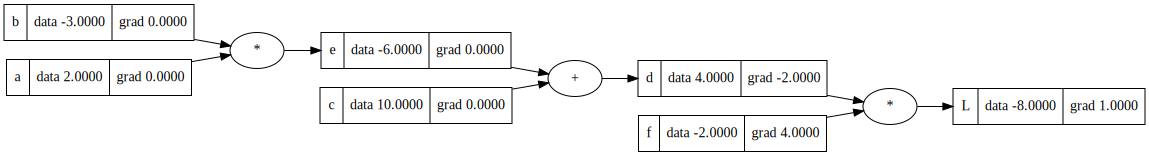

In [1371]:
draw_dot(L)

We manually calculate first order derivative dL/dd and dL/df. 

Now we need to calculate dL/de and dL/dc

This invokes chain rule. We leverage the already known gradients dL/dd and dL/df.

dL/de = dL/dd * dd/de = -2 * dd/de

and dL/dc = dL/dd * dd/dc = 4 * dd/dc

We must solve for the two remaining terms by calculating their first order derivative.

d = e+c

dd/de = 1 (e is a linear function)
dL/de = dL/de = dL/dd * dd/de = -2 * dd/de = -2 * 1 = -2

dd/dc = 1 (c is also a linear function)
dL/dc = dL/dd * dd/dc = -2 * dd/dc = -2 * 1 = -2

In [1372]:
e.grad = -2
c.grad = -2

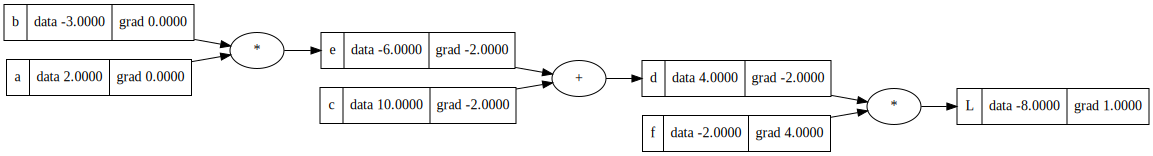

In [1373]:
draw_dot(L)

now we need dL/db and dL/da.

for brevity, we can spell out the entire chain rule algorithm here.

dL/db = dL/dd * dd/de * de/db  
dL/da = dL/dd * dd/de * de/da 

We know dL/dd * dd/de = -2 from our last expression (this is also e.grad)

dL/db = -2 * de/db 
dL/da = -2 * de/da

e = a*b
de/da = b = -3
de/db = a = 2 

dL/db = -2 * de/db = -2 * 2  = -4  
dL/da = -2 * de/da = -2 * - 3= 6 

All local derivatives are calculated. Backprop is essentially the recursive application of chain rule.

In [1374]:
b.grad = -4
a.grad = 6

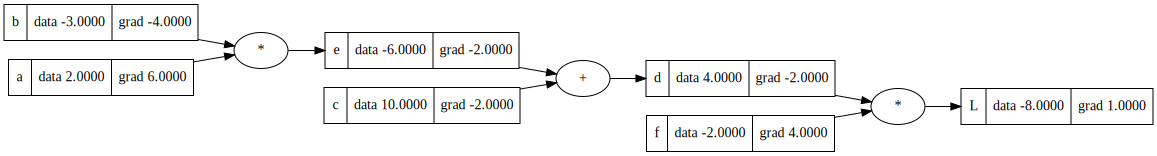

In [1375]:
draw_dot(L)

We want to nudge our inputs to make L go up. We nudge each node in the direction of the gradient. We only do this for leaf nodes (those listed in cell below) as these are typically cells we have control over (deeper nodes are generally hidden layers and are obfuscated from user POV)

In [1376]:
a.data+= 0.01*a.grad
b.data+= 0.01*b.grad
c.data+= 0.01*c.grad
f.data+= 0.01*f.grad

#forward pass to see how new data impacts hidden layers and output L node 
e = a * b
d = e + c
L = d * f

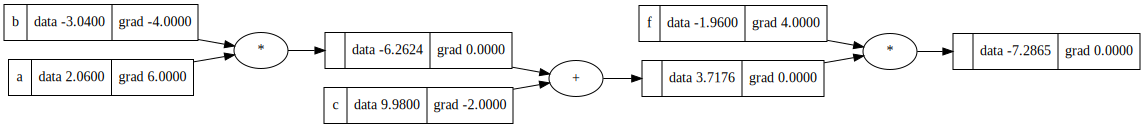

In [1377]:
#forward pass
draw_dot(L)

Restart and build a self sufficeint neural network without the need to self calculate the gradients at each step. New formula and weights with two variable, x1, x2

In [1378]:
#x1 and x2 are inputs. 
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')

#w1 and w2 are weights.
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label = 'w2')

#neuron bias. may help us achieve a better fit to input data.
b = Value (6.8813735870195432, label='b');

x1w1 = x1*w1; x1w1.label = 'x1w1'
x2w2 = x2*w2; x2w2.label = 'x2w2'

x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1w1x2w2'

n = x1w1x2w2 + b; n.label = 'n'

o = n.tanh(); 

In [1379]:
n._prev

{Value(data=-6.0), Value(data=6.881373587019543)}

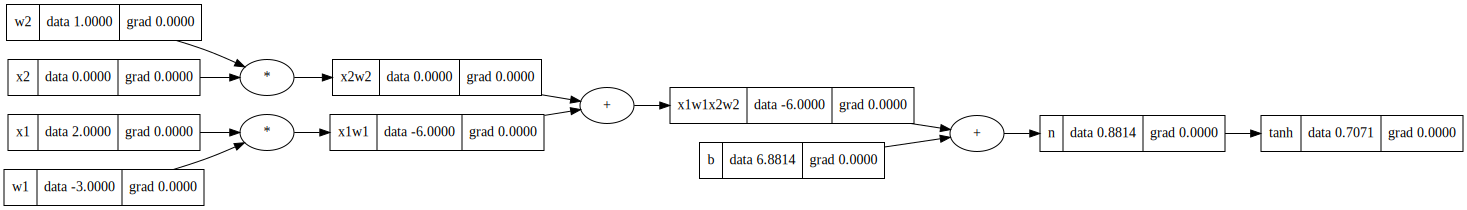

In [1380]:
draw_dot(o)

Hand calculate gradients

a. dO/dO = 1  
b. dO/dn = sech^2(n)  (derivative of tanh(x)) = sech^2(0.8814) = .5  
c. dO/db = d0/dn * dn/db = .5 * d(x1w1x2w2 + b)/ db = .5 * 1 = 1 (although b is a constant)  
d. dO/(x1w1 + x2w2) = d0/dn * dn/(x1w1 + x2w2) = sech^2(n) + 0 =  = .5  
e. dO/(x1w1) = dO/(x1w1 + x2w2) * d(x1w1 + x2w2)/d(x1w1) = .5 * 1 = .5  
f. dO/(x2w2) =  dO/(x1w1 + x2w2) * d(x1w1 + x2w2)/d(x2w2) = .5 * 1 = .5  
g. dO/(w2) = dO/d(x2w2) * d(x2w2)/d(w2) = .5 * x2 = .5 * 0 = 0  
h. dO/(w1) = dO/(x1w1) * dO/w1 = .5 * x1 = .5 * 2 = 1  



In [1381]:
# o.grad = 1.0
# n.grad=.5
# x1w1x2w2.grad = .5
# x1w1.grad = .5
# x2w2.grad = .5

o.backward()

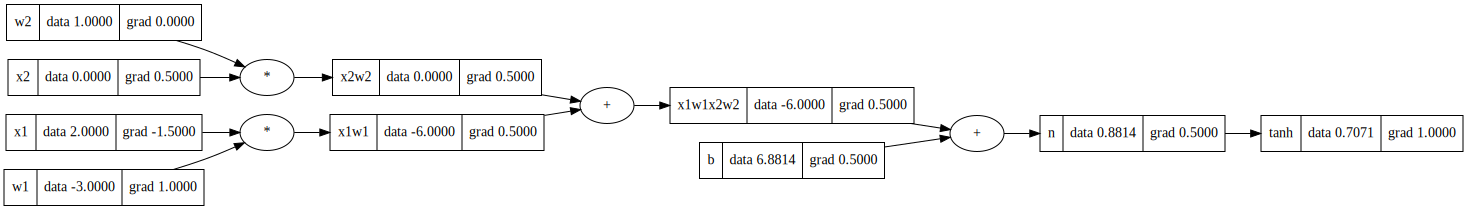

In [1382]:
draw_dot(o)

In [1383]:
o.grad = 1.0

In [1384]:
o._backward()

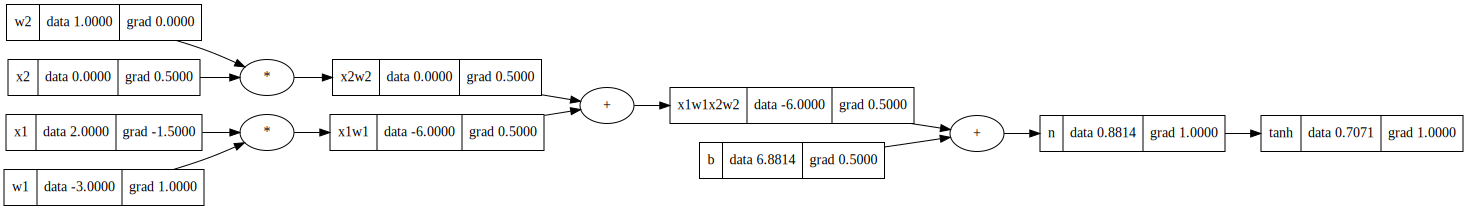

In [1385]:
draw_dot(o)

In [1386]:
n._backward()

In [1387]:
x1w1x2w2._backward()

In [1388]:
x1w1._backward()
x2w2._backward()

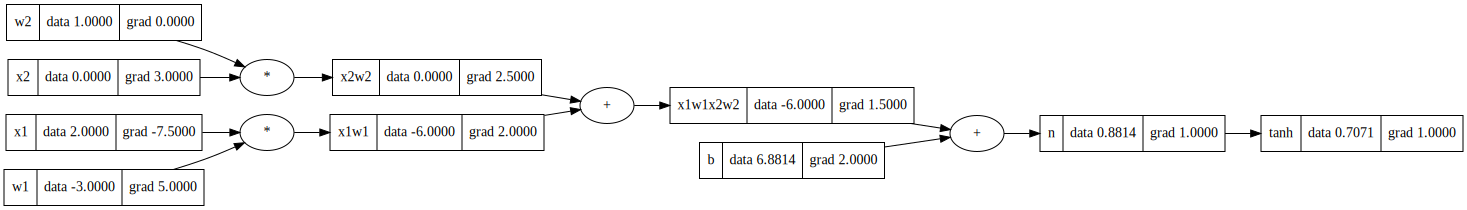

In [1389]:
draw_dot(o)

How do we automate this? Topological sort helps us sort the graph such that all the dependencies are laid out left to right, with the one with the most dependencies on the left and least on the right. 

In [1390]:
topo = []
visited = set()
def build_topo(v):
    if v not in visited:
        visited.add(v)
        for child in v._prev:
            build_topo(child)
        topo.append(v)
build_topo(o)
topo

[Value(data=2.0),
 Value(data=-3.0),
 Value(data=-6.0),
 Value(data=1.0),
 Value(data=0.0),
 Value(data=0.0),
 Value(data=-6.0),
 Value(data=6.881373587019543),
 Value(data=0.8813735870195432),
 Value(data=0.7071067811865476)]

Implementing this with Pytorch

In [1391]:
import torch
import random

In [1392]:
#represents Value.data
x1 = torch.Tensor([2.0]).double(); x1.requires_grad = True
x2 = torch.Tensor([0.0]).double(); x2.requires_grad = True
w1 = torch.Tensor([-3.0]).double(); w1.requires_grad = True
w2 = torch.Tensor([1.0]).double(); w2.requires_grad = True
b = torch.Tensor([6.8813735870195432]).double(); b.requires_grad = True
n = x1*w1 + x2*w2 + b
o = torch.tanh(n)

print("forward pass:")
print(o.data.item())
o.backward()
print("backward pass")
print('x2', x2.grad.item())
print('w2', w2.grad.item())
print('x1', x1.grad.item())
print('w1', w1.grad.item())



forward pass:
0.7071066904050358
backward pass
x2 0.5000001283844369
w2 0.0
x1 -1.5000003851533106
w1 1.0000002567688737


In [1393]:
torch.Tensor([2.0]).double().dtype

torch.float64

Build neural net from scratch

In [1394]:
#nin is dimensionality of neurons
class Neuron:
    def __init__(self, nin):
        self.w = [Value(random.uniform(-1,1)) for _ in range(nin)]
        self.b = Value(random.uniform(-1,1))

    def __call__(self,x):
        #w * x + b dot product
        act = sum((wi*xi for wi, xi in zip(self.w, x)), self.b)
        out = act.tanh()
        return out;

    def parameters(self):
       return self.w + [self.b];

class Layer:
    def __init__(self, nin, nout):
        self.neurons = [Neuron(nin) for _ in range(nout)]

    def __call__(self, x):
        outs = [n(x) for n in self.neurons]
        return outs[0] if len(outs) == 1 else outs

    def parameters(self): 
        return [p for neuron in self.neurons for p in neuron.parameters()]

class MLP: 
    def __init__(self, nin, nouts):
        sz = [nin] + nouts
        self.layers = [Layer(sz[i], sz[i+1]) for i in range (len(nouts))]

    def __call__(self, x):
        for layer in self.layers:
            x=layer(x)
        return x

    def parameters(self):
        return [p for layer in self.layers for p in layer.parameters()];
        
# x=[2.0, 3.0, -1.0]
# n(x)

In [1395]:
n = MLP(3, [4, 4, 1])
# draw_dot(n(x))

In [1396]:
xs = [
  [2.0, 3.0, -1.0],
  [3.0, -1.0, 0.5],
  [0.5, 1.0, 1.0],
  [1.0, 1.0, -1.0],
]
ys = [1.0, -1.0, -1.0, 1.0] # desired targets

In [1414]:
for k in range(20):
    #forward_pass
    ypred = [n(x) for x in xs]
    loss = sum((yout-ygt)**2 for ygt, yout in zip (ys, ypred))

    # reset gradients to zero because we do += in gradients
    for p in n.parameters():
        p.grad = 0;
        
    # loss computed now calculate gradients 
    loss.backward()
    #update
    for p in n.parameters():
        #-0.05 step 
        step_size = -0.05
        p.data += -0.05 * p.grad

    print (k, loss.data)

0 0.0035669225554569453
1 0.00355151209982406
2 0.003535391664101
3 0.0035202992771843815
4 0.0035053464217164074
5 0.003490820100621144
6 0.0034756786486192836
7 0.003461040271480173
8 0.003446953259078774
9 0.0034325611225107817
10 0.0034174876189079035
11 0.003403362965036407
12 0.0033893065227766327
13 0.0033746820586401855
14 0.0033605095440829495
15 0.0033461812927681783
16 0.0033321128842016337
17 0.0033188632569017768
18 0.003304779273002407
19 0.003291063861470738


In [1415]:
ypred

[Value(data=0.9715536412766982),
 Value(data=-0.9686778209811934),
 Value(data=-0.9732444486705285),
 Value(data=0.9719833957906063)]